# Stock prediction tool

**Available currencies:**

> **Bitcoin** - BTC-USD<br>
> **Ethereum** - ETH-USD<br>
> **BNB** - BNB-USD<br>
> **Dogecoin** - DOGE-USD<br>

In [1]:
import yfinance
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score, cross_validate
from sklearn.metrics import make_scorer, r2_score, roc_auc_score, RocCurveDisplay, classification_report,\
                                confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler

from functools import partial

In [2]:
bitcoin = yfinance.Ticker("BTC-USD")
ethereum = yfinance.Ticker("ETH-USD")
bincoin = yfinance.Ticker("BNB-USD")
dogecoin = yfinance.Ticker("DOGE-USD")

currency_names = ["Bitcoin", "Ethereum",
                  "Binance Coin", "Dogecoin"]

currencies_data = [bitcoin.history(period="max"), ethereum.history(period="max"),
                   bincoin.history(period="max"), dogecoin.history(period="max")]

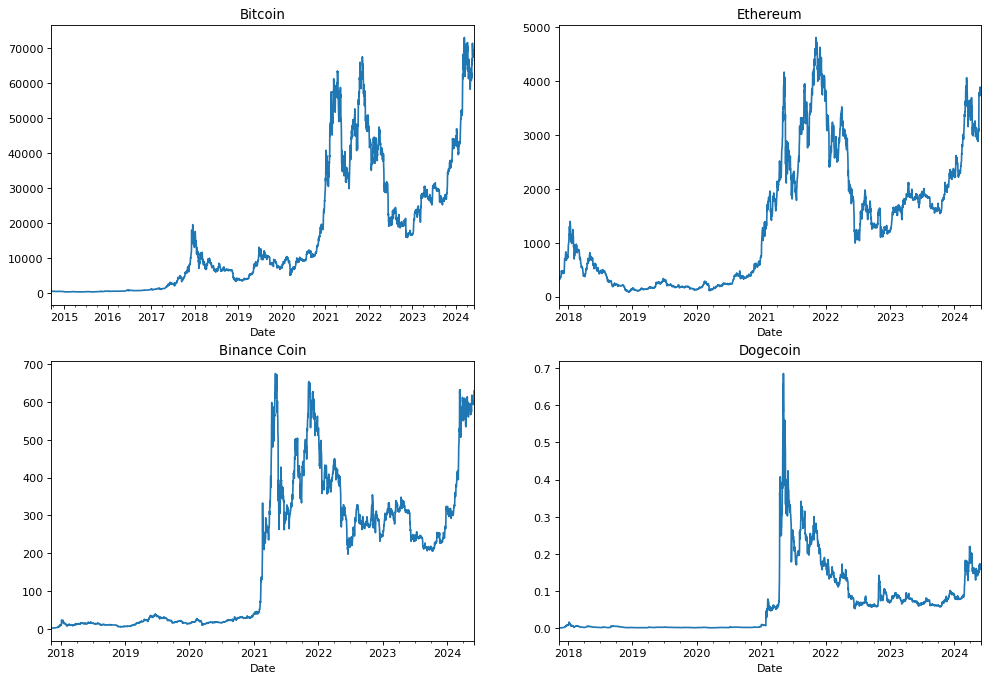

In [3]:
fig, axes = plt.subplots(figsize=(15,10), dpi=80, nrows=2, ncols=2)

for ax, name, data in zip(axes.flatten(), currency_names, currencies_data):
    data["Close"].plot(ax=ax)
    ax.set_title(name)

In [4]:
bitcoin_data = currencies_data[0]
bitcoin_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,0.0,0.0
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0.0,0.0
...,...,...,...,...,...,...,...
2024-05-30 00:00:00+00:00,67576.085938,69500.539062,67118.078125,68364.992188,29509712534,0.0,0.0
2024-05-31 00:00:00+00:00,68362.515625,68999.562500,66633.421875,67491.414062,27387283769,0.0,0.0
2024-06-01 00:00:00+00:00,67489.609375,67839.765625,67386.195312,67706.937500,11641495604,0.0,0.0


In [5]:
def RSI(data: pd.Series, window: int = 14) -> pd.Series:
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [6]:
past_prices_values = [1, 3, 7, 14, 30, 200]
window_values = [3, 7, 14, 30, 50, 200]

for pp in past_prices_values:
    bitcoin_data[f"{pp}D"] = bitcoin_data["Close"].shift(pp)

for window in window_values:
    # MOVING AVERAGE
    bitcoin_data[f"{window}DA"] = bitcoin_data["Close"].rolling(window=window).mean()
    # EXPONENTIAL MOVING AVERAGE
    bitcoin_data[f"{window}DEA"] = bitcoin_data["Close"].ewm(span=window, adjust=False).mean()
    # RSI
    bitcoin_data[f"{window}RSI"] = RSI(bitcoin_data["Close"].copy(), window=window)

# TARGET VARIABLE
bitcoin_data["Growth"] = (bitcoin_data["Close"] > bitcoin_data["1D"]).astype(int)

bitcoin_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,1D,3D,7D,...,30DA,30DEA,30RSI,50DA,50DEA,50RSI,200DA,200DEA,200RSI,Growth
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0,NaN,NaN,NaN,...,NaN,457.334015,NaN,NaN,457.334015,NaN,NaN,457.334015,NaN,0
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0,457.334015,NaN,NaN,...,NaN,455.211821,NaN,NaN,456.044054,NaN,NaN,457.006711,NaN,0
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0,424.440002,NaN,NaN,...,NaN,451.314025,NaN,NaN,453.642169,NaN,NaN,456.387699,NaN,0
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,0.0,0.0,394.795990,457.334015,NaN,...,NaN,448.577894,NaN,NaN,451.887730,NaN,NaN,455.915224,NaN,1
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0.0,0.0,408.903992,424.440002,NaN,...,NaN,445.367773,NaN,NaN,449.806683,NaN,NaN,455.347123,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-30 00:00:00+00:00,67576.085938,69500.539062,67118.078125,68364.992188,29509712534,0.0,0.0,67578.093750,69394.554688,67929.562500,...,65192.147396,66517.637998,59.384132,64902.850000,65638.603937,48.385851,53975.814473,55410.606933,56.599713,1
2024-05-31 00:00:00+00:00,68362.515625,68999.562500,66633.421875,67491.414062,27387283769,0.0,0.0,68364.992188,68296.218750,68526.101562,...,65500.060807,66580.462261,61.643582,64851.466094,65711.263157,48.143718,54130.759766,55530.813969,56.523126,0
2024-06-01 00:00:00+00:00,67489.609375,67839.765625,67386.195312,67706.937500,11641495604,0.0,0.0,67491.414062,67578.093750,69265.945312,...,65786.177604,66653.138082,61.000696,64861.687500,65789.524896,50.383954,54291.606250,55651.969427,56.792989,1


In [7]:
bitcoin_data = bitcoin_data.dropna()
bitcoin_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,1D,3D,7D,...,30DA,30DEA,30RSI,50DA,50DEA,50RSI,200DA,200DEA,200RSI,Growth
Date,,,,,,,,,,,,,,,,,,,,,
2015-04-05 00:00:00+00:00,253.761002,260.674988,251.942001,260.597992,19649200,0.0,0.0,253.697006,253.005005,242.712997,...,265.654567,257.536366,46.401498,259.639901,258.807999,50.561944,309.859490,306.873610,44.397749,1
2015-04-06 00:00:00+00:00,260.721008,261.798004,254.574997,255.492004,20034200,0.0,0.0,260.597992,254.322006,247.526001,...,264.962268,257.404472,43.892944,260.053241,258.677960,53.768809,309.014750,306.362350,45.111678,0
2015-04-07 00:00:00+00:00,255.274002,255.804993,252.205002,253.179993,18467400,0.0,0.0,255.492004,253.697006,244.223999,...,264.256468,257.131925,43.788641,260.439981,258.462354,53.509247,308.306670,305.833173,45.836650,0
2015-04-08 00:00:00+00:00,253.063995,253.847000,244.214996,245.022003,30086400,0.0,0.0,253.179993,260.597992,247.272003,...,262.770301,256.350639,36.353000,260.468221,257.935281,50.257753,307.487260,305.228086,45.165140,0
2015-04-09 00:00:00+00:00,244.751007,246.117996,239.399994,243.675995,21643500,0.0,0.0,245.022003,255.492004,253.005005,...,261.167501,255.532920,35.208913,260.615221,257.376093,51.371431,306.711535,304.615628,45.399181,0


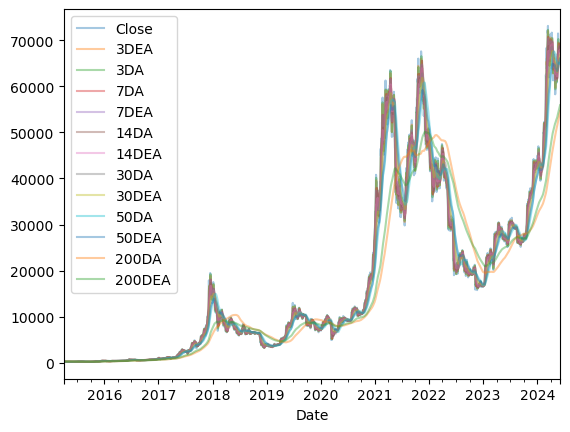

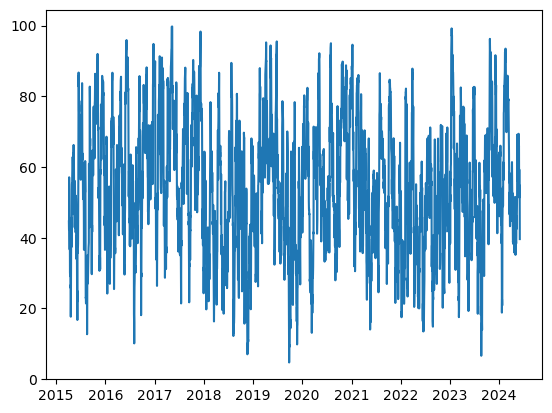

In [8]:
bitcoin_data[["Close", "3DEA", "3DA", "7DA", "7DEA", "14DA", "14DEA", "30DA", "30DEA", "50DA", "50DEA", "200DA", "200DEA"]].plot(alpha=0.4)
plt.show()

plt.plot(bitcoin_data["14RSI"])

In [9]:
features = ["Open", "High", "Low", "Close", "Volume",
            "1D", "3D", "7D", "14D", "30D", "200D",
            "3DA", "7DA", "14DA", "30DA", "50DA", "200DA",
            "3DEA", "7DEA", "14DEA", "30DEA", "50DEA", "200DEA",
            "3RSI", "7RSI", "14RSI", "30RSI", "50RSI", "200RSI"]

def check_model(model, data: pd.DataFrame, features: list, target: str, test_size: int = 300, threshold: float = 0.6):
    X = bitcoin_data[features].values
    y = bitcoin_data[target].values

    n_size = len(X)

    # Train Test Split
    X_train = X[:n_size-test_size, :]
    X_test = X[n_size-test_size:, :]
    
    y_train = y[:n_size-test_size]
    y_test = y[n_size-test_size:]

    # Fitting the model
    model.fit(X_train, y_train)

    # Predicting with a threshold
    y_pred = model.predict_proba(X_test)[:,1]
    y_pred[y_pred > threshold] = 1
    y_pred[y_pred <= threshold] = 0

    # Displaying the results
    print(classification_report(y_test, y_pred))

    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    plt.show()


              precision    recall  f1-score   support

           0       0.57      0.89      0.69       143
           1       0.79      0.39      0.52       157

    accuracy                           0.63       300
   macro avg       0.68      0.64      0.61       300
weighted avg       0.69      0.63      0.60       300



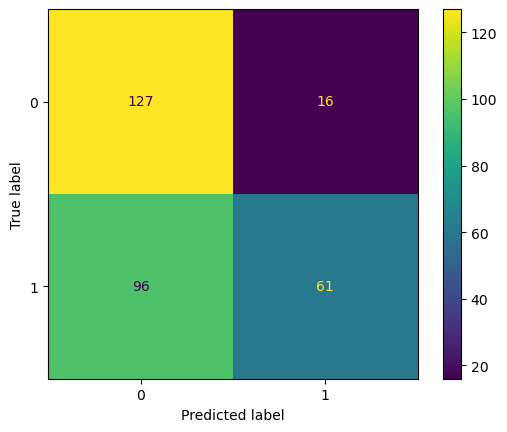

In [10]:
rf = RandomForestClassifier(bootstrap=False)

check_model(rf, bitcoin_data, features, "Growth")

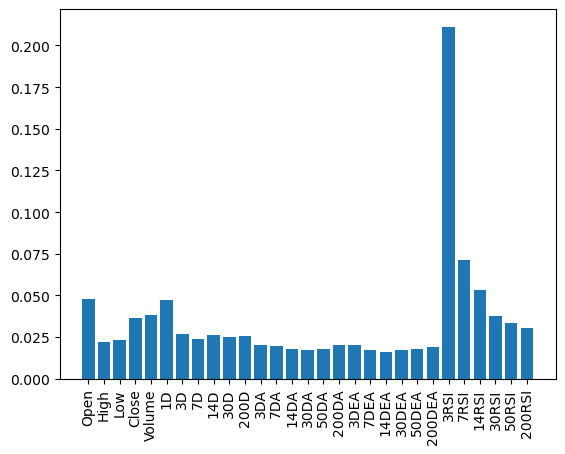

In [11]:
plt.bar(range(1, len(features)+1), rf.feature_importances_)
plt.xticks(range(1, len(features)+1), features)
plt.xticks(rotation=90)
plt.show()

In [12]:
rfe = RFE(RandomForestClassifier())
rfe.fit(bitcoin_data[features], bitcoin_data["Growth"])

RFE(estimator=RandomForestClassifier())

In [13]:
features_rfe = list(np.array(features)[rfe.ranking_ == 1])

              precision    recall  f1-score   support

           0       0.58      0.86      0.69       143
           1       0.77      0.43      0.56       157

    accuracy                           0.64       300
   macro avg       0.68      0.65      0.62       300
weighted avg       0.68      0.64      0.62       300



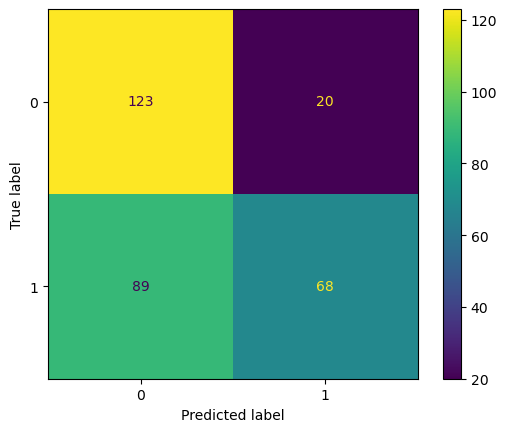

In [14]:
features_cut = ["Open", "Close", "Volume", "1D", "30D", "200DA", "200DEA", "3RSI", "7RSI", "14RSI", "30RSI", "50RSI", "200RSI"]

rf_cut = RandomForestClassifier()
check_model(rf_cut, bitcoin_data, features_rfe, "Growth")

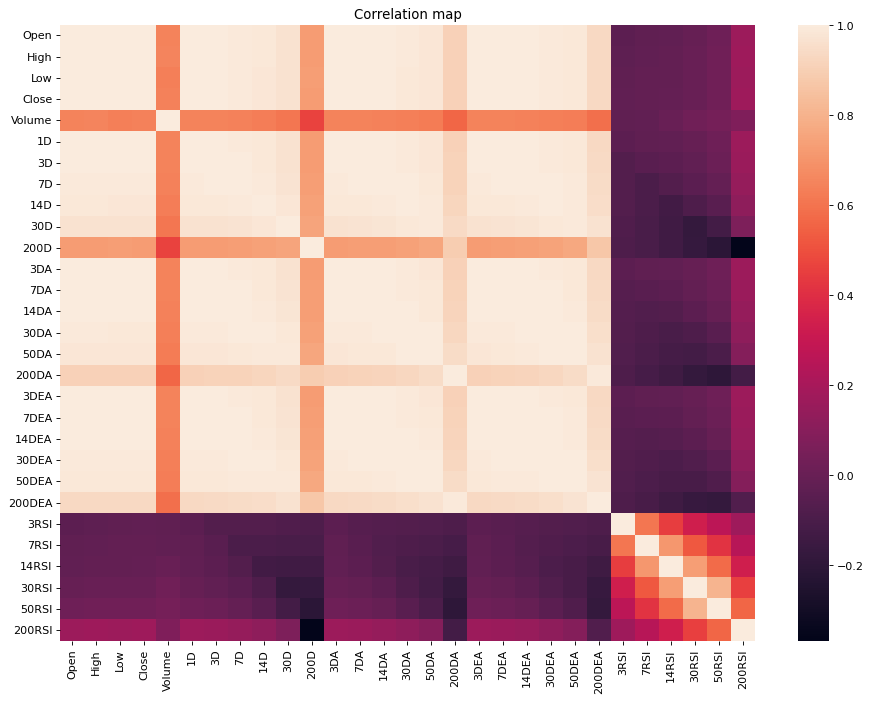

In [15]:
plt.figure(figsize=(14,10), dpi=80)
sns.heatmap(bitcoin_data[features].corr())
plt.title("Correlation map")
plt.show()

In [16]:
splitter = TimeSeriesSplit(n_splits=5)

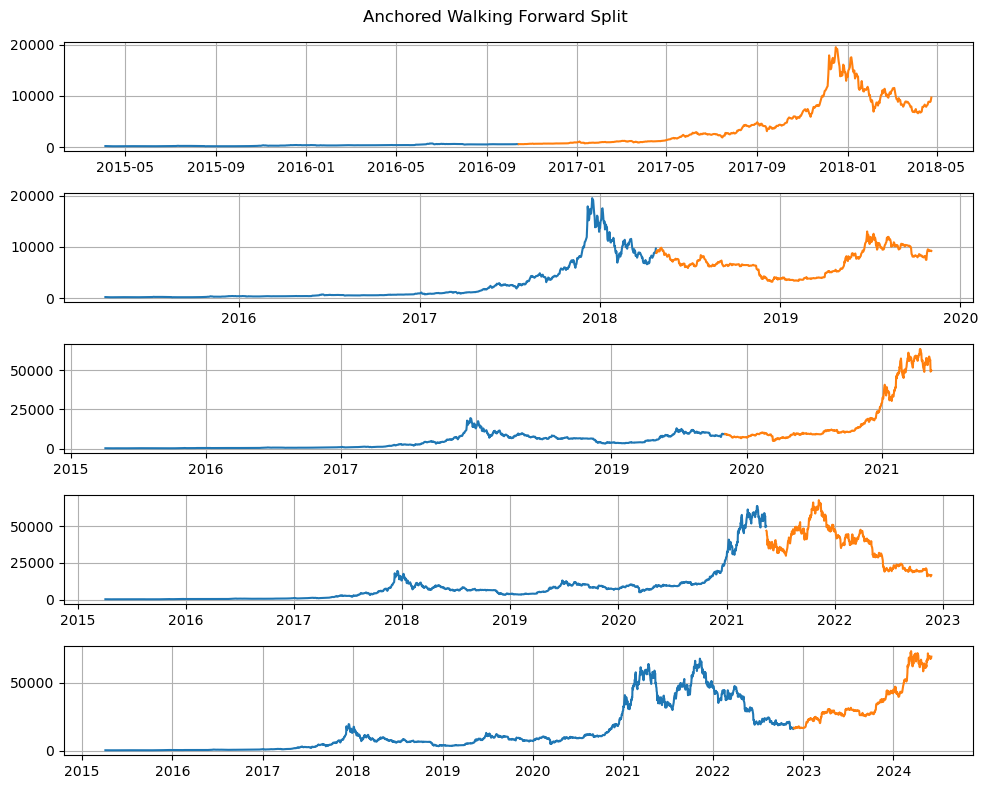

In [17]:
fig, axes = plt.subplots(figsize=(10, 8), nrows=5)

for ax, (x_s, t_s) in zip(axes.flatten(), splitter.split(bitcoin_data)):
    data_part_train = bitcoin_data.iloc[x_s, :]
    data_part_test = bitcoin_data.iloc[t_s, :]
    ax.plot(data_part_train["Close"])
    ax.plot(data_part_test["Close"])
    ax.grid()
fig.suptitle("Anchored Walking Forward Split")
plt.tight_layout()

In [18]:
def prediction_scorer_threshold(model, X: np.array, y: np.array, threshold: float = 0.6, scoring=precision_score) -> float:
    """
    Calculates the given metric, classifing the class 1 under the condition of exceeding the given probability threshold..
    """
    y_prob = model.predict_proba(X)[:, 1]
    y_pred = (y_prob > threshold).astype(int)

    return scoring(y, y_pred, pos_label=1, zero_division=0)
    

def check_model_awf(model, X: np.array, y: np.array, splits: int = 5, threshold: float = 0.6) -> float:
    """
    Cross-validates the Time Series data with Anchored Walking Forward approach.
    """
    cvts = TimeSeriesSplit(n_splits=splits)
    return np.mean(cross_val_score(model, X, y, cv=cvts, scoring=partial(prediction_scorer_threshold, threshold=threshold)))


def check_model_rwf(model, X: np.array, y: np.array, max_train_size: int = 500, test_size: int = 100, threshold: float = 0.6) -> float:
    """
    Cross-validates the Time Series data with Rolling Walking Forward approach.
    """
    splits = (len(X)-max_train_size)//test_size
    cvts = TimeSeriesSplit(n_splits=splits, max_train_size=max_train_size, test_size=test_size)
    return np.nanmean(cross_val_score(model, X, y, cv=cvts, scoring=partial(prediction_scorer_threshold, threshold=threshold)))

In [19]:
Xf = bitcoin_data[features].values
yf = bitcoin_data["Growth"].values

Xfc = bitcoin_data[features_cut].values
yfc = bitcoin_data["Growth"].values

Xfr = bitcoin_data[features_rfe].values
yfr = bitcoin_data["Growth"].values

In [20]:
titles = ["All features", "Features picked by rf importances", "Features picked by RFE"]
for name, (X, y) in zip(titles, [(Xf, yf), (Xfc, yfc), (Xfr, yfr)]):
    print(f"--- --- --- --- --- --- {name} --- --- --- --- --- ---")
    print("--- --- --- Raw Random Forest Anchored Walking Forward Cross-validation Score --- --- ---")
    print(check_model_awf(rf, Xf, yf, splits=10))
    print("--- --- --- Raw Random Forest Rolling Walking Forward Cross-validation Score --- --- ---")
    print(check_model_rwf(rf, Xf, yf))
    print("\n\n\n")

--- --- --- --- --- --- All features --- --- --- --- --- ---
--- --- --- Raw Random Forest Anchored Walking Forward Cross-validation Score --- --- ---
0.8392421689308319
--- --- --- Raw Random Forest Rolling Walking Forward Cross-validation Score --- --- ---
0.7618583972694052




--- --- --- --- --- --- Features picked by rf importances --- --- --- --- --- ---
--- --- --- Raw Random Forest Anchored Walking Forward Cross-validation Score --- --- ---
0.8341949848167394
--- --- --- Raw Random Forest Rolling Walking Forward Cross-validation Score --- --- ---
0.7707020128217424




--- --- --- --- --- --- Features picked by RFE --- --- --- --- --- ---
--- --- --- Raw Random Forest Anchored Walking Forward Cross-validation Score --- --- ---
0.8430936073939307
--- --- --- Raw Random Forest Rolling Walking Forward Cross-validation Score --- --- ---
0.7648679506997169






In [21]:
bitcoin_data.shape

(3348, 32)

In [22]:
def cross_validate_rts(model, X, y, threshold=0.6):
    """
    Creates a Real-Time-Scenario backtesting cross-validation.
    """
    n_rows = len(X)
    cv = TimeSeriesSplit(max_train_size=n_rows-150, test_size=1, n_splits=150)
    y_test = []
    y_pred = []
    for train_id, test_id in cv.split(X):
        model.fit(X[train_id], y[train_id])
        y_prob = model.predict_proba(X[test_id])[:,1]
        y_pred.append(y_prob > threshold)
        y_test.append(y[test_id])
    return np.ravel(np.array(y_test)), np.ravel(np.array(y_pred))

## Real-time-scenario for pure Random Forest estimator

In [23]:
res = cross_validate_rts(RandomForestClassifier(bootstrap=False), Xfc, yfc)

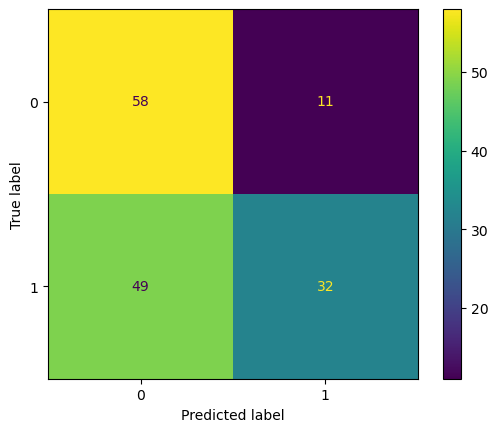

              precision    recall  f1-score   support

           0       0.54      0.84      0.66        69
           1       0.74      0.40      0.52        81

    accuracy                           0.60       150
   macro avg       0.64      0.62      0.59       150
weighted avg       0.65      0.60      0.58       150



In [24]:
yt, yp = res
ConfusionMatrixDisplay(confusion_matrix(np.ravel(yt), np.ravel(yp))).plot()
plt.show()
print(classification_report(np.ravel(yt), np.ravel(yp)))

In [42]:
scaler = MinMaxScaler()

X_train = Xfc[:3000]
X_test = Xfc[3000:]

y_train = yfc[:3000]
y_test = yfc[3000:]

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(Xfc)

### Hyperparams tuning - 1st run

In [26]:
params = {
    "max_depth": [6, 8, 12, 16, 20],
    "n_estimators": [100, 200, 300]
}

rf_cv = GridSearchCV(RandomForestClassifier(bootstrap=False),
                     params,
                     cv=TimeSeriesSplit(n_splits=10), 
                     scoring=prediction_scorer_threshold,
                     n_jobs=-1)

rf_cv.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=RandomForestClassifier(bootstrap=False), n_jobs=-1,
             param_grid={'max_depth': [6, 8, 12, 16, 20],
                         'n_estimators': [100, 200, 300]},
             scoring=<function prediction_scorer_threshold at 0x000001B7807F5940>)

In [27]:
print(rf_cv.best_params_)
print(rf_cv.best_score_)

{'max_depth': 6, 'n_estimators': 200}
0.8901977836502344


### 2nd run<br>
**Params**:

- max_depth: 7
- n_estimators: 250

In [28]:
params = {
    "max_depth": [6, 7],
    "n_estimators": [250, 300, 350]
}

rf_cv2 = GridSearchCV(RandomForestClassifier(bootstrap=False),
                     params,
                     cv=TimeSeriesSplit(n_splits=10), 
                     scoring=prediction_scorer_threshold,
                     n_jobs=-1)

rf_cv2.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=RandomForestClassifier(bootstrap=False), n_jobs=-1,
             param_grid={'max_depth': [6, 7], 'n_estimators': [250, 300, 350]},
             scoring=<function prediction_scorer_threshold at 0x000001B7807F5940>)

In [29]:
print(rf_cv2.best_params_)
print(rf_cv2.best_score_)

{'max_depth': 7, 'n_estimators': 250}
0.8916073437941361


## Checking the best Random Forest estimator in real-time-scenario

It gave the wrong "buy" decision only 3 times, however missess about 70% of opportunities.<br>
It's not bad, however it is also not perfect.

In [30]:
rf_best = RandomForestClassifier(bootstrap=False, max_depth=7, n_estimators=250)

rfb_res = cross_validate_rts(rf_best, Xfc, yfc)

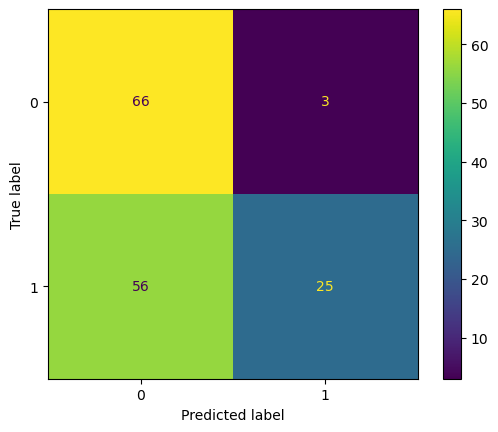

              precision    recall  f1-score   support

           0       0.54      0.96      0.69        69
           1       0.89      0.31      0.46        81

    accuracy                           0.61       150
   macro avg       0.72      0.63      0.57       150
weighted avg       0.73      0.61      0.57       150



In [31]:
yt, yp = rfb_res
ConfusionMatrixDisplay(confusion_matrix(yt, yp)).plot()
plt.show()
print(classification_report(yt, yp))

# Support Vector Machines

Now let's check how the **SVM** will do with this problem.<br>
Looking at the initial results, I am going to try **hyperoptimize the SVM**.<br>
<br>
Another thing, that I have noticed is the time it takes SVM and RF to train and predict. It is way better in terms of SVM.

In [32]:
print("--- --- --- --- --- --- SVC --- --- --- --- --- ---")
print("--- --- --- Raw SVC Anchored Walking Forward Cross-validation Score --- --- ---")
print(check_model_awf(SVC(probability=True), X_train_scaled, y_train, splits=10))
print("--- --- --- Raw SVC Rolling Walking Forward Cross-validation Score --- --- ---")
print(check_model_rwf(SVC(probability=True), X_train_scaled, y_train))
print("\n\n\n")

--- --- --- --- --- --- SVC --- --- --- --- --- ---
--- --- --- Raw SVC Anchored Walking Forward Cross-validation Score --- --- ---
0.7292934921463707
--- --- --- Raw SVC Rolling Walking Forward Cross-validation Score --- --- ---
0.7286699443701916






In [34]:
params = {
    "C": [0.01, 0.1, 1, 10, 50, 100, 200, 300],
    "gamma": [1, 0.1, 0.001, 0.0001],
    "kernel": ["linear", "rbf"]
}

svm_cv = GridSearchCV(SVC(probability=True),
                     params,
                     cv=TimeSeriesSplit(n_splits=10), 
                     scoring=prediction_scorer_threshold,
                     n_jobs=-1)

svm_cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 50, 100, 200, 300],
                         'gamma': [1, 0.1, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf']},
             scoring=<function prediction_scorer_threshold at 0x000001B7807F5940>)

In [35]:
print(svm_cv.best_score_)
print(svm_cv.best_params_)

0.8235443601802638
{'C': 300, 'gamma': 0.1, 'kernel': 'linear'}


### 2nd run

**Params**:

- C: 500
- gamma: 0.1
- kernel: linear

In [36]:
params = {
    "C": [250, 300, 350, 400, 450, 500],
    "gamma": [0.1, 0.05, 0.01]
}

svm_cv2 = GridSearchCV(SVC(kernel="linear", probability=True),
                     params,
                     cv=TimeSeriesSplit(n_splits=10), 
                     scoring=prediction_scorer_threshold,
                     n_jobs=-1)

svm_cv2.fit(X_train_scaled, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=SVC(kernel='linear', probability=True), n_jobs=-1,
             param_grid={'C': [250, 300, 350, 400, 450, 500],
                         'gamma': [0.1, 0.05, 0.01]},
             scoring=<function prediction_scorer_threshold at 0x000001B7807F5940>)

In [37]:
print(svm_cv2.best_score_)
print(svm_cv2.best_params_)

0.8329743252094429
{'C': 500, 'gamma': 0.1}


### 3rd run

**Params:**<br>

- C: **1100**
- gamma: **0.05**
- kernel: **linear**

In [40]:
params = {
    "C": [900, 950, 1000, 1100, 1200],
    "gamma": [0.1, 0.05]
}

svm_cv3 = GridSearchCV(SVC(kernel="linear", probability=True),
                     params,
                     cv=TimeSeriesSplit(n_splits=10), 
                     scoring=prediction_scorer_threshold,
                     n_jobs=-1)

svm_cv3.fit(X_train_scaled, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=SVC(kernel='linear', probability=True), n_jobs=-1,
             param_grid={'C': [900, 950, 1000, 1100, 1200],
                         'gamma': [0.1, 0.05]},
             scoring=<function prediction_scorer_threshold at 0x000001B7807F5940>)

In [41]:
print(svm_cv3.best_score_)
print(svm_cv3.best_params_)

0.8555426535244027
{'C': 1100, 'gamma': 0.05}


### WARNING!!!

LONG TIME OF EXECUTION

### Evaluation on Real-Time-Scenario

SVM gave incredibely good results in a RTS simulation:

- **Precision**: 100%
- **Recall**: 94%

In [43]:
svm_best = svm_cv3.best_estimator_
svm_res = cross_validate_rts(svm_best, X_scaled, yfc)

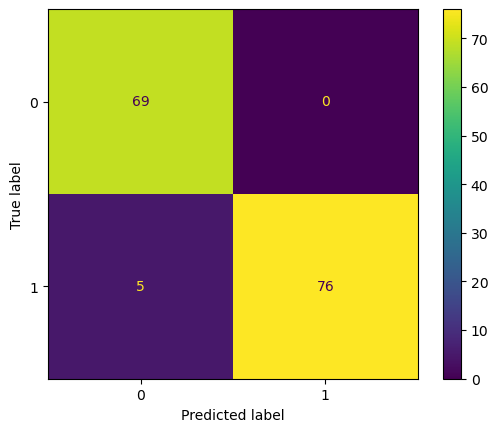

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        69
           1       1.00      0.94      0.97        81

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



In [44]:
yt, yp = svm_res
ConfusionMatrixDisplay(confusion_matrix(yt, yp)).plot()
plt.show()
print(classification_report(yt, yp))

# AdaBoost
AdaBoost gave surprisingly good results, however I find this suspicious. I need to look into it a little bit.

In [45]:
print("--- --- --- --- --- --- AdaBoost --- --- --- --- --- ---")
print("--- --- --- Raw AdaBoost Anchored Walking Forward Cross-validation Score --- --- ---")
print(check_model_awf(AdaBoostClassifier(algorithm="SAMME"), X_train, y_train, splits=10))
print("--- --- --- Raw AdaBoost Rolling Walking Forward Cross-validation Score --- --- ---")
print(check_model_rwf(AdaBoostClassifier(algorithm="SAMME"), X_train, y_train))
print("\n\n\n")

--- --- --- --- --- --- AdaBoost --- --- --- --- --- ---
--- --- --- Raw AdaBoost Anchored Walking Forward Cross-validation Score --- --- ---
0.9856382553021209
--- --- --- Raw AdaBoost Rolling Walking Forward Cross-validation Score --- --- ---
0.9694748477083311






### First insight

Altought the model has incredibly high precision (what I'm aiming for), but the problem is with the recall score, perhaps AdaBoost needs lower threshold.

              precision    recall  f1-score   support

           0       0.55      1.00      0.71       143
           1       1.00      0.25      0.41       157

    accuracy                           0.61       300
   macro avg       0.78      0.63      0.56       300
weighted avg       0.79      0.61      0.55       300



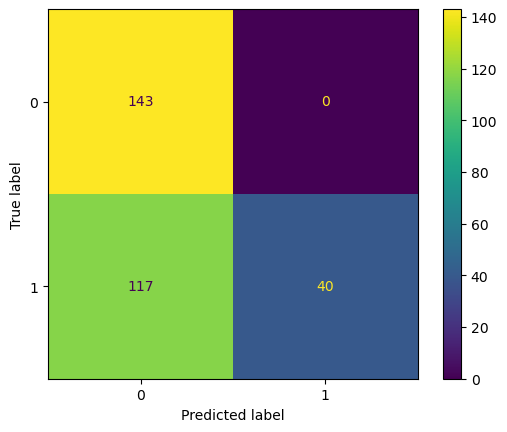

In [46]:
check_model(AdaBoostClassifier(algorithm="SAMME"), X, features_cut, "Growth")

In [47]:
print("--- --- --- --- --- --- AdaBoost --- --- --- --- --- ---")
print("--- --- --- Raw AdaBoost Anchored Walking Forward Cross-validation Score --- --- ---")
print(check_model_awf(AdaBoostClassifier(algorithm="SAMME"), X_train, y_train, splits=10, threshold=0.55))
print("--- --- --- Raw AdaBoost Rolling Walking Forward Cross-validation Score --- --- ---")
print(check_model_rwf(AdaBoostClassifier(algorithm="SAMME"), X_train, y_train, threshold=0.55))
print("\n\n\n")

--- --- --- --- --- --- AdaBoost --- --- --- --- --- ---
--- --- --- Raw AdaBoost Anchored Walking Forward Cross-validation Score --- --- ---
0.8766510737768518
--- --- --- Raw AdaBoost Rolling Walking Forward Cross-validation Score --- --- ---
0.8813990250014857






### Let's check the new results

It does not change in this particular situation, I need to make a real day-to-day simulation on this model in order to check how it really performs.

              precision    recall  f1-score   support

           0       0.55      1.00      0.71       143
           1       1.00      0.25      0.41       157

    accuracy                           0.61       300
   macro avg       0.78      0.63      0.56       300
weighted avg       0.79      0.61      0.55       300



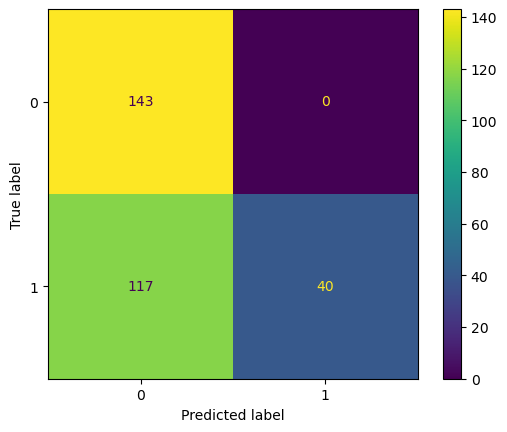

In [48]:
check_model(AdaBoostClassifier(algorithm="SAMME"), X, features_cut, "Growth", threshold=0.55)

### AdaBoost in RTS

It gives **100% precision**, but with only **27% of recall**. I need to check, what will happen with lower threshold.

In [50]:
ada_res = cross_validate_rts(AdaBoostClassifier(algorithm="SAMME"), Xfc, yfc, threshold=0.6)

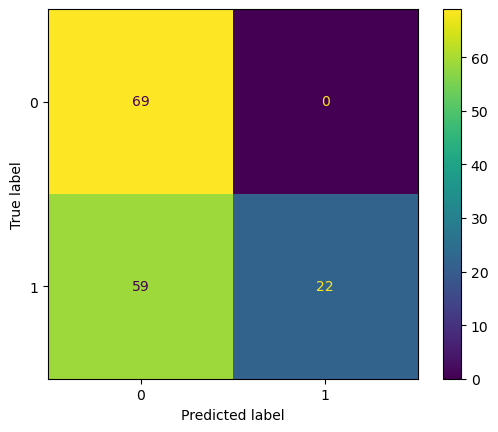

              precision    recall  f1-score   support

           0       0.54      1.00      0.70        69
           1       1.00      0.27      0.43        81

    accuracy                           0.61       150
   macro avg       0.77      0.64      0.56       150
weighted avg       0.79      0.61      0.55       150



In [51]:
yt, yp = ada_res
ConfusionMatrixDisplay(confusion_matrix(yt, yp)).plot()
plt.show()
print(classification_report(yt, yp))

### It gives pretty average results

I think that I am going to leave the threshold of **0.6**, but hypertuned.

In [54]:
ada_res = cross_validate_rts(AdaBoostClassifier(algorithm="SAMME"), Xfc, yfc, threshold=0.5)

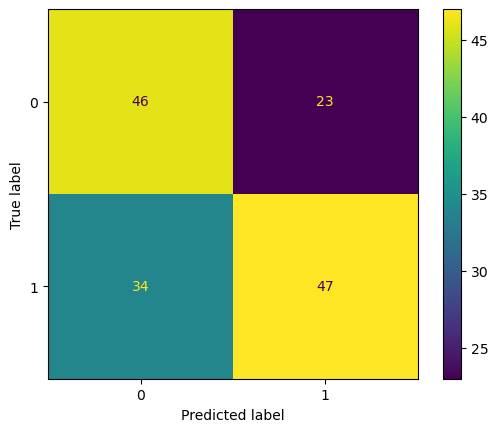

              precision    recall  f1-score   support

           0       0.57      0.67      0.62        69
           1       0.67      0.58      0.62        81

    accuracy                           0.62       150
   macro avg       0.62      0.62      0.62       150
weighted avg       0.63      0.62      0.62       150



In [55]:
yt, yp = ada_res
ConfusionMatrixDisplay(confusion_matrix(yt, yp)).plot()
plt.show()
print(classification_report(yt, yp))

# AdaBoost hypertuning

There is not much to change in terms of this estimator, however it can serve as an **ultimate agreement** in terms of decision (additional confirmation).

In [59]:
params = {
    "n_estimators": [30, 40, 50, 60, 70, 80],
    "learning_rate": [1, 0.05, 0.1, 0.15, 0.2, 0.25]
}

ada_cv = GridSearchCV(AdaBoostClassifier(algorithm="SAMME"),
                      params,
                      cv=TimeSeriesSplit(n_splits=10),
                      scoring=partial(prediction_scorer_threshold, scoring=recall_score),
                      n_jobs=-1)

ada_cv.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=AdaBoostClassifier(algorithm='SAMME'), n_jobs=-1,
             param_grid={'learning_rate': [1, 0.05, 0.1, 0.15, 0.2, 0.25],
                         'n_estimators': [30, 40, 50, 60, 70, 80]},
             scoring=functools.partial(<function prediction_scorer_threshold at 0x000001B7807F5940>, scoring=<function recall_score at 0x000001B7FC24ACA0>))

In [60]:
print(ada_cv.best_params_)
print(ada_cv.best_score_)

{'learning_rate': 0.05, 'n_estimators': 30}
0.2644600996269103


In [61]:
ada_best = ada_cv.best_estimator_
ada_res = cross_validate_rts(ada_best, Xfc, yfc)

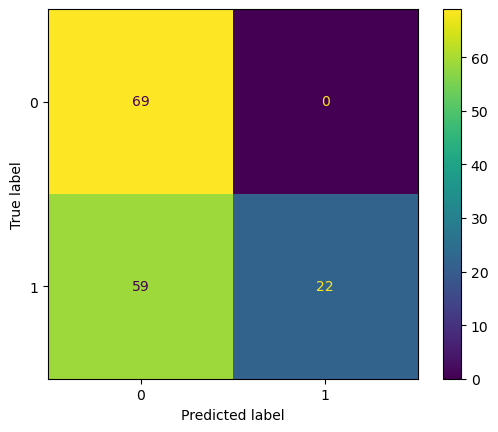

              precision    recall  f1-score   support

           0       0.54      1.00      0.70        69
           1       1.00      0.27      0.43        81

    accuracy                           0.61       150
   macro avg       0.77      0.64      0.56       150
weighted avg       0.79      0.61      0.55       150



In [62]:
yt, yp = ada_res
ConfusionMatrixDisplay(confusion_matrix(yt, yp)).plot()
plt.show()
print(classification_report(yt, yp))

# GradientBoost

Let's start with RTS cross-validation.<br>
It looks like it has potential and I can go with further optimalization.

In [63]:
gb_res = cross_validate_rts(GradientBoostingClassifier(), Xfc, yfc)

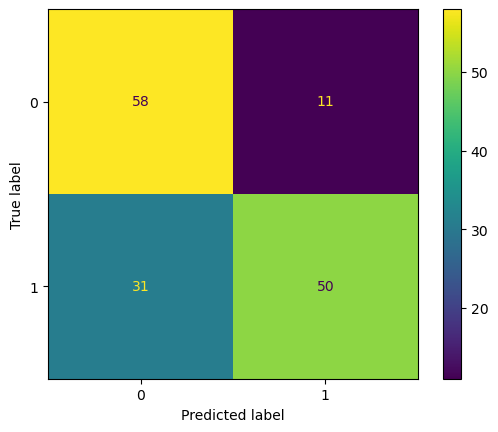

              precision    recall  f1-score   support

           0       0.65      0.84      0.73        69
           1       0.82      0.62      0.70        81

    accuracy                           0.72       150
   macro avg       0.74      0.73      0.72       150
weighted avg       0.74      0.72      0.72       150



In [64]:
yt, yp = gb_res
ConfusionMatrixDisplay(confusion_matrix(yt, yp)).plot()
plt.show()
print(classification_report(yt, yp))

# ToDo
3. LSTM
4. Various ML algorythms
---
5. River - online learning

In [195]:
bitcoin_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3546 entries, 2014-09-17 00:00:00+00:00 to 2024-06-01 00:00:00+00:00
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3546 non-null   float64
 1   High          3546 non-null   float64
 2   Low           3546 non-null   float64
 3   Close         3546 non-null   float64
 4   Volume        3546 non-null   int64  
 5   Dividends     3546 non-null   float64
 6   Stock Splits  3546 non-null   float64
 7   1D            3545 non-null   float64
 8   3D            3543 non-null   float64
 9   7D            3539 non-null   float64
 10  14D           3532 non-null   float64
 11  30D           3516 non-null   float64
 12  200D          3346 non-null   float64
 13  3DA           3544 non-null   float64
 14  3DEA          3546 non-null   float64
 15  3RSI          3544 non-null   float64
 16  7DA           3540 non-null   float64
 17  7DEA          3546 non-